# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from wordcloud import WordCloud

from tqdm import tqdm
import os

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:

# using the SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [0]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [19]:
final_string=[]
for i, sent in enumerate(tqdm(final['Text'].values)):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    final_string.append(str1)

#############---- storing the data into .sqlite file ------########################
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")


100%|██████████| 364171/364171 [05:50<00:00, 1040.24it/s]


In [20]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...


In [0]:
#Taking sample of data
sample_data = final[0:100000]

In [0]:
sample_data = sample_data.sort_values(by='Time')

In [114]:
sample_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#Breaking into Train and test
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(sample_data['CleanedText'].values,sample_data['Score'].values,test_size=0.3)

In [117]:
#Bow
bow_vect = CountVectorizer()
X_train =bow_vect.fit_transform(X_train)
X_test = bow_vect.transform(X_test)
print ('='*50)
print("the type of count vectorizer ",type(X_train))
print("the shape of out text BOW vectorizer ",X_train.get_shape())
print("the number of unique words ", X_train.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70000, 31555)
the number of unique words  31555


In [0]:
import warnings
#Standardizing our data matrir
from sklearn.preprocessing import StandardScaler
Scalar = StandardScaler(with_mean=False)


In [0]:
X_train = Scalar.fit_transform(X_train)


In [0]:
X_test = Scalar.transform(X_test)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   59.0s finished


Best HyperParameter:  {'C': 0.01}
Best Accuracy: 89.09%


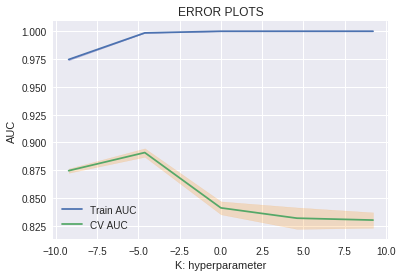

In [121]:
from sklearn.model_selection import GridSearchCV
from math import log
from sklearn.linear_model import LogisticRegression

K = [10**-4, 10**-2, 10**0, 10**2, 10**4]

Model= LogisticRegression()
parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]  
gsv = GridSearchCV(Model,parameters,cv=2,verbose=1,scoring = 'roc_auc' , n_jobs=-1)
gsv.fit(X_train,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']
optimal_C = gsv.best_params_
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

log_K = []
for i in K:
    log_K.append(log(i))

plt.plot(log_K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


###[4.1.1]  Applying Logistic Regression with L1 regularization on BOW

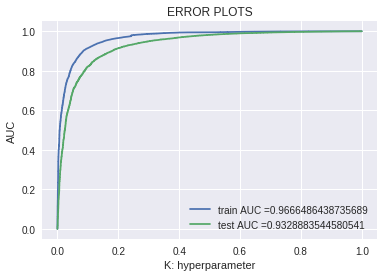

In [122]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

optimal_lambda = optimal_C['C']
neigh = LogisticRegression(C=optimal_lambda, penalty='l1')
neigh.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Test data confusion matrix


Text(0.5, 1.0, 'Confusion Matrix')

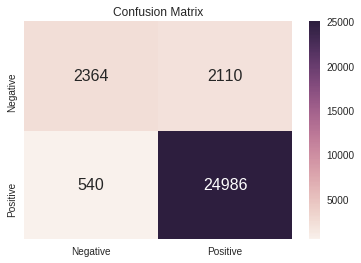

In [123]:
from sklearn.metrics import confusion_matrix
#Test data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(X_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [124]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.53      0.64      4474
           1       0.92      0.98      0.95     25526

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.87      0.75      0.80     30000
weighted avg       0.91      0.91      0.90     30000



###[4.1.2] Calculating sparsity on weight vector obtained using L1 regularization

**C=0.01**

In [125]:
weight_vector = neigh.coef_
print("Number of non-zero for λ value of 0.01 = "+str(np.count_nonzero(weight_vector)))

Number of non-zero for λ value of 0.01 = 3637


**C=0.1**

In [126]:
neigh1 = LogisticRegression(C=0.1, penalty='l1')
neigh1.fit(X_train, y_train)

print("Number of non-zero for λ value of 0.1 = "+str(np.count_nonzero(neigh1.coef_)))

Number of non-zero for λ value of 0.1 = 10631


**c=10**

In [127]:
neigh2 = LogisticRegression(C=10, penalty='l1')
neigh2.fit(X_train, y_train)

print("Number of non-zero for λ value of 10 = "+str(np.count_nonzero(neigh2.coef_)))

Number of non-zero for λ value of 10 = 14293


###[4.1.3] Applying Logistic Regression with L2 regularization on BOW

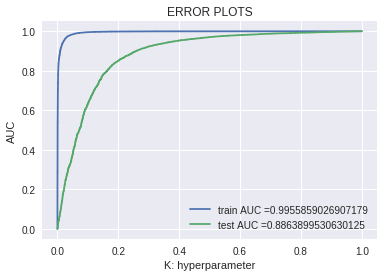

In [128]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

optimal_lambda = optimal_C['C']
neigh = LogisticRegression(C=optimal_lambda, penalty='l2')
neigh.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Test data confusion matrix


Text(0.5, 1.0, 'Confusion Matrix')

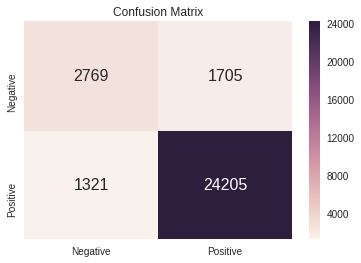

In [129]:
from sklearn.metrics import confusion_matrix
#Test data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(X_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [130]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4474
           1       0.93      0.95      0.94     25526

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.81      0.78      0.79     30000
weighted avg       0.90      0.90      0.90     30000



###[4.1.4] Performing pertubation test or checking multicollinearity  on BOW

In [131]:
print (X_train.shape)
X_train_new = X_train
X_train_new.data = X_train_new.data +0.01;
print (X_train_new.shape)

(70000, 31555)
(70000, 31555)


In [0]:
#Now we will fit our model with this noise added data since we need to check for multicollinearity
neigh = LogisticRegression(C=optimal_C['C'], penalty='l1')
neigh.fit(X_train_new, y_train)
y_preb = neigh.predict(X_test)
weight_vector2 = neigh.coef_

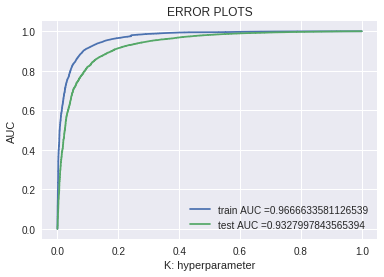

In [133]:
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
#Adding some noise data to weight vector obtained before and after adding some noise into it.
weight_vector = weight_vector[0] + 0.000001;
weight_vector2 = weight_vector2[0] +0.000001;
weight_vector = list(weight_vector)
weight_vector2 = list(weight_vector2)

#### finding change in the percentage of weight vector 

In [0]:
percentage_change_vector = []
for i in range(0,len(weight_vector)):
    x=(abs((weight_vector[i]-(weight_vector2[i]))/(weight_vector[i])))*100
    percentage_change_vector.append(x)

#### Calculating 0th,10th,100th percentile and checking if there is sudden rise in percentile value that we obtained before

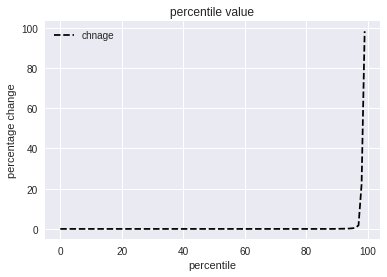

In [136]:
percentile_value = []
percentile = []
i= 0
while i <100:
    percentile.append(i)
    percentile_value.append(np.percentile(percentage_change_vector,i))
    i = i+1;
    
# percentile_value
plt.plot(percentile, percentile_value, 'k--',label='chnage')
plt.xlabel('percentile')
plt.ylabel('percentage change')
plt.title("percentile value")
plt.legend()
plt.show()

** As we can see in our graph that  at approx between 90 or 95  and 100 we have sudden rise so  let's look it by printing percentile between 90 and 10**

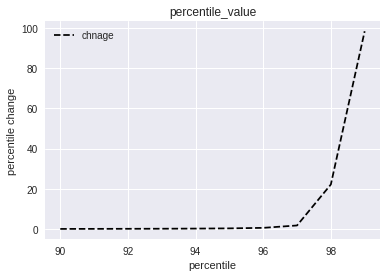

Percentile value from 90 to 99

[90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[0.03756366413808692, 0.0665225584739441, 0.09864585251931696, 0.13678753909782737, 0.20113043072276993, 0.30834692506776634, 0.5677081050864845, 1.7523823025093475, 22.115852954125003, 98.30546674104508]


In [137]:
percentile_val90 = []
percentile90 = []
j= 90
while j <100:
    percentile90.append(j)
    percentile_val90.append(np.percentile(percentage_change_vector,j))
    j = j+1;
    
plt.plot(percentile90, percentile_val90, 'k--',label='chnage')
plt.xlabel('percentile')
plt.ylabel('percentile change')
plt.title("percentile_value")
plt.legend()
plt.show()

print("Percentile value from 90 to 99\n")
print(percentile90)
print(percentile_val90)

**So by plotting the graph we can see that we are getting elbow at 98 lets have look in that range**

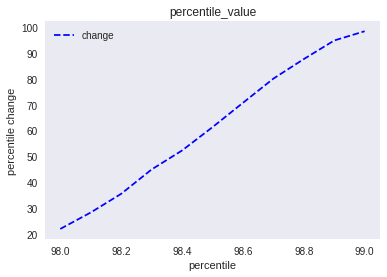

Percentile value from 98.0 to 99.0

[98, 98.1, 98.19999999999999, 98.29999999999998, 98.39999999999998, 98.49999999999997, 98.59999999999997, 98.69999999999996, 98.79999999999995, 98.89999999999995, 98.99999999999994]
[22.115852954125003, 28.444032972398343, 35.64610164762623, 45.026888356963, 52.337754879019464, 61.33099513179145, 70.70979373194257, 80.03124440391754, 87.57216678326316, 94.7429730417172, 98.30546674104352]


In [138]:
percentile_val90 = []
percentile90 = []
j= 98
while j <=99:
    percentile90.append(j)
    percentile_val90.append(np.percentile(percentage_change_vector,j))
    j = j+0.1;
    
plt.plot(percentile90, percentile_val90, 'b--',label='change')
plt.xlabel('percentile')
plt.ylabel('percentile change')
plt.title("percentile_value")
plt.legend()
plt.grid()
plt.show()

print("Percentile value from 98.0 to 99.0\n")
print(percentile90)
print(percentile_val90)

**So by plottint the graph we can see that we are getting our threshold value around 15 or 16 so we will take 15.50 as our threshold value bcoz features having value above this threshold value are  having multicollinearity so we cant trust this feature as they shown sudden change after adding noise in it.**

In [139]:
#Storing the feature having value more then the threshold 
w = []  #defining w as variable for value above threshold
count = 0;
for i in range(0,len(percentage_change_vector)):
    if percentage_change_vector[i] > 15.50:
        count = count +1;
        w.append(weight_vector[i])
    else:
        w.append(0.0)
        
print(count)


677


#### Features whose percentage change more then threshold

In [0]:
feature_names = bow_vect.get_feature_names()
topfeature = sorted(zip(w, feature_names), reverse=True)[:] 
features_list = []
for coef, feat in topfeature:
    if coef != 0.0 :
        features_list.append(feat)

feature_with_collinearity = features_list;

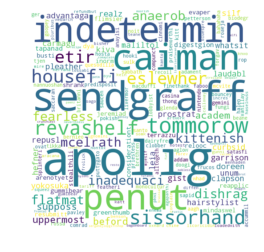

In [141]:
wordcloud = WordCloud(width=600, height=600, margin=0,background_color="white").generate(" ".join(feature_with_collinearity))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [0]:
feature_names = bow_vect.get_feature_names()
topNegative = sorted(zip(weight_vector, feature_names), reverse=False)[:10]
topPositive = sorted(zip(weight_vector, feature_names), reverse=True)[:10]

In [0]:
negative_features_name_list =[]
positive_features_name_list =[]
for coef, feat in topPositive:
    positive_features_name_list.append(feat)
    
for coef, feat in topNegative:
    negative_features_name_list.append(feat)

###[4.1.5] Feature Importance

####Top negative features

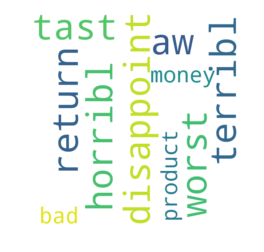

In [144]:
wordcloud = WordCloud(width=600, height=600, margin=0,background_color="white").generate(" ".join(negative_features_name_list))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

####Top positive features

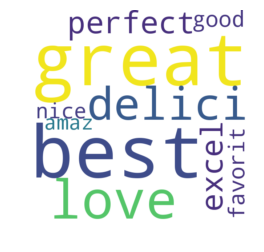

In [145]:
wordcloud = WordCloud(width=600, height=600, margin=0,background_color="white").generate(" ".join(positive_features_name_list))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

##[5.2]Logistic Regression on TFIDF

In [0]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(sample_data['CleanedText'].values,sample_data['Score'].values,test_size=0.3)

tfidf = TfidfVectorizer(ngram_range=(1,2) ,min_df=10) #Using bi-grams
X_train_tfidf = tfidf.fit_transform(X_train)

X_test_tfidf = tfidf.transform(X_test)


In [0]:
import warnings
#Standardizing our data matrir
from sklearn.preprocessing import StandardScaler
Scalar = StandardScaler(with_mean=False)

X_train_tfidf = Scalar.fit_transform(X_train_tfidf)

X_test_tfidf = Scalar.transform(X_test_tfidf)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.7s finished


Best HyperParameter:  {'C': 0.0001}
Best Accuracy: 92.85%


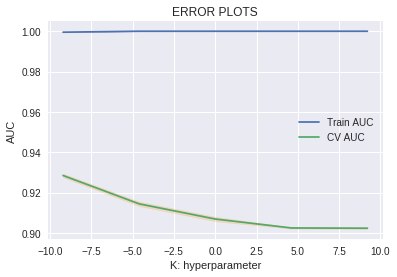

In [148]:
from sklearn.model_selection import GridSearchCV
from math import log
from sklearn.linear_model import LogisticRegression

K = [10**-4, 10**-2, 10**0, 10**2, 10**4]

Model= LogisticRegression()
parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]  
gsv = GridSearchCV(Model,parameters,cv=2,verbose=1,scoring = 'roc_auc' , n_jobs=-1)
gsv.fit(X_train_tfidf,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']
optimal_C = gsv.best_params_
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

log_K = []
for i in K:
    log_K.append(log(i))

plt.plot(log_K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


###[5.2.1]Applying Logistic Regression with L1 regularization on TFIDF

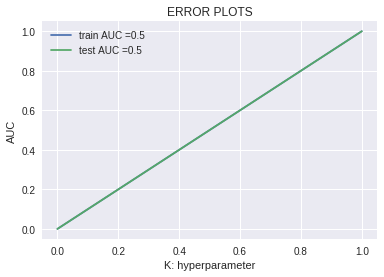

In [149]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

optimal_lambda = optimal_C['C']
Modell1 = LogisticRegression(C=optimal_lambda, penalty='l1')
Modell1.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = Modell1.predict_proba(X_test_tfidf)

train_fpr, train_tpr, thresholds = roc_curve(y_train, Modell1.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, Modell1.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Test data confusion matrix


Text(0.5, 1.0, 'Confusion Matrix')

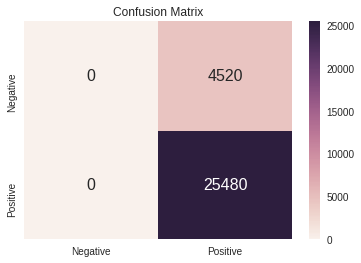

In [150]:
from sklearn.metrics import confusion_matrix
#Test data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,Modell1.predict(X_test_tfidf))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [151]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,Modell1.predict(X_test_tfidf)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4520
           1       0.85      1.00      0.92     25480

   micro avg       0.85      0.85      0.85     30000
   macro avg       0.42      0.50      0.46     30000
weighted avg       0.72      0.85      0.78     30000



###[5.2.2]Applying Logistic Regression with L2 regularization on TFIDF

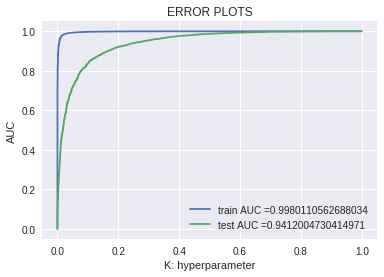

In [152]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

optimal_lambda = optimal_C['C']
neighl2 = LogisticRegression(C=optimal_lambda, penalty='l2')
neighl2.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neighl2.predict_proba(X_test_tfidf)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neighl2.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neighl2.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Test data confusion matrix


Text(0.5, 1.0, 'Confusion Matrix')

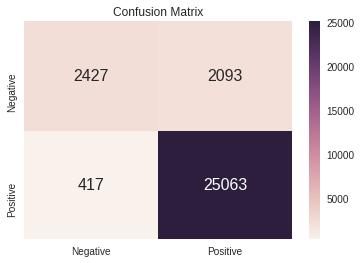

In [153]:
from sklearn.metrics import confusion_matrix
#Test data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neighl2.predict(X_test_tfidf))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [154]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neighl2.predict(X_test_tfidf)))

              precision    recall  f1-score   support

           0       0.85      0.54      0.66      4520
           1       0.92      0.98      0.95     25480

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.89      0.76      0.81     30000
weighted avg       0.91      0.92      0.91     30000



##[5.3] Logistic Regression on AVG W2V

In [0]:
# Train our own Word2Vec model on train data using our own text corpus
list_of_sent_train=[]
for sent in X_train:
    list_of_sent_train.append(sent.split())

In [156]:
print(X_train[0])
print("*****************************************************************")
print(list_of_sent_train[0])

disappoint tast dri blueberri sweet sick unnatur sweet unlik blueberri previous look ingredi clear wild blueberri good corn syrup there caus ugh sugar mayb okay corn syrup gone dont need much sugar dri fruit natur flavor uhhh natur ad citric acid sunflow oil potassium sorbat big ingredi could forgiv flavor right horribl donat rest food bank hope someon like tast get enjoy go differ supplier dri fruit need enjoy cherri past afraid tri anyth els compani
*****************************************************************
['disappoint', 'tast', 'dri', 'blueberri', 'sweet', 'sick', 'unnatur', 'sweet', 'unlik', 'blueberri', 'previous', 'look', 'ingredi', 'clear', 'wild', 'blueberri', 'good', 'corn', 'syrup', 'there', 'caus', 'ugh', 'sugar', 'mayb', 'okay', 'corn', 'syrup', 'gone', 'dont', 'need', 'much', 'sugar', 'dri', 'fruit', 'natur', 'flavor', 'uhhh', 'natur', 'ad', 'citric', 'acid', 'sunflow', 'oil', 'potassium', 'sorbat', 'big', 'ingredi', 'could', 'forgiv', 'flavor', 'right', 'horribl',

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model1=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)

In [158]:
w2v_words1 = list(w2v_model1.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words1))

number of words that occured minimum 5 times  10709


In [0]:
list_sent_test = []
for sent in X_test:
    list_sent_test.append(sent.split())

In [160]:
print (X_test[0])
print("=="*50)
print (list_sent_test[0])

love chip would buy home vermont time theyr favorit new york wish could find store instead purchas bulk onlin salt vinegar favorit snack ever brand chip compar
['love', 'chip', 'would', 'buy', 'home', 'vermont', 'time', 'theyr', 'favorit', 'new', 'york', 'wish', 'could', 'find', 'store', 'instead', 'purchas', 'bulk', 'onlin', 'salt', 'vinegar', 'favorit', 'snack', 'ever', 'brand', 'chip', 'compar']


#### Avg word2vec

In [161]:
# average Word2Vec on train data
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 70000/70000 [01:34<00:00, 741.15it/s]

70000
50


In [162]:
# average Word2Vec on train data
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_sent_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 30000/30000 [00:40<00:00, 735.40it/s]

30000
50


###Gridsearch

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.5s finished


Best HyperParameter:  {'C': 1}
Best Accuracy: 90.66%


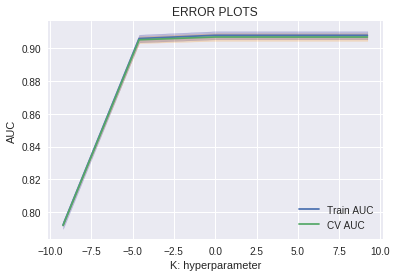

In [163]:
from sklearn.model_selection import GridSearchCV
from math import log
from sklearn.linear_model import LogisticRegression

K = [10**-4, 10**-2, 10**0, 10**2, 10**4]

Model= LogisticRegression()
parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]  
gsv = GridSearchCV(Model,parameters,cv=2,verbose=1,scoring = 'roc_auc' , n_jobs=-1)
gsv.fit(sent_vectors_train,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']
optimal_C = gsv.best_params_
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

log_K = []
for i in K:
    log_K.append(log(i))

plt.plot(log_K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


###[5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V

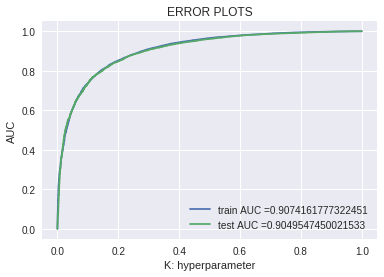

In [164]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

optimal_lambda = optimal_C['C']
neigh = LogisticRegression(C=optimal_lambda, penalty='l1')
neigh.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred_train = neigh.predict_proba(sent_vectors_train)
y_pred_test = neigh.predict_proba(sent_vectors_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train,y_pred_train[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_test[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Test data confusion matrix


Text(0.5, 1.0, 'Confusion Matrix')

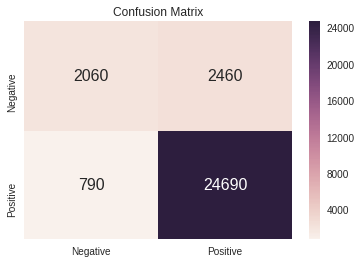

In [165]:
from sklearn.metrics import confusion_matrix
#Tain data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(sent_vectors_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [166]:
#Accuraccy on train data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(sent_vectors_test)))

              precision    recall  f1-score   support

           0       0.72      0.46      0.56      4520
           1       0.91      0.97      0.94     25480

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.82      0.71      0.75     30000
weighted avg       0.88      0.89      0.88     30000



###[5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V

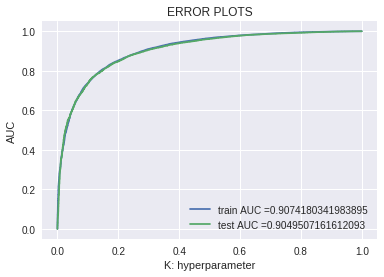

In [167]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

optimal_lambda = optimal_C['C']
neigh = LogisticRegression(C=optimal_lambda, penalty='l2')
neigh.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred_train = neigh.predict_proba(sent_vectors_train)
y_pred_test = neigh.predict_proba(sent_vectors_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train,y_pred_train[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_test[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Test data confusion matrix


Text(0.5, 1.0, 'Confusion Matrix')

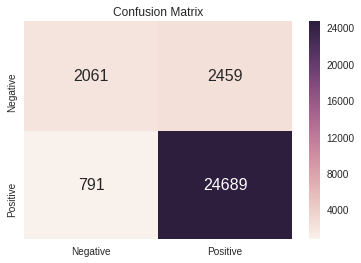

In [168]:
from sklearn.metrics import confusion_matrix
#Test data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(sent_vectors_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [169]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(sent_vectors_test)))

              precision    recall  f1-score   support

           0       0.72      0.46      0.56      4520
           1       0.91      0.97      0.94     25480

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.82      0.71      0.75     30000
weighted avg       0.88      0.89      0.88     30000



##[5.4] Logistic Regression on TFIDF W2V

In [170]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_train)

# we are converting a dictionary with word as a key, and the tfidf as a value
dictionary1 = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

type(final_tf_idf)

scipy.sparse.csr.csr_matrix

In [0]:
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary1[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [0]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_sent_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary1[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

###Gridsearch

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.4s finished


Best HyperParameter:  {'C': 1}
Best Accuracy: 88.10%


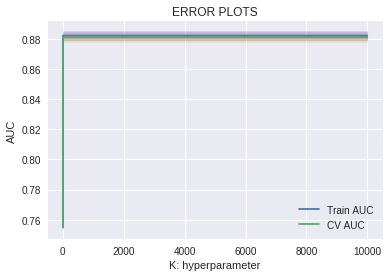

In [173]:
from sklearn.model_selection import GridSearchCV
from math import log
from sklearn.linear_model import LogisticRegression

K = [10**-4, 10**-2, 10**0, 10**2, 10**4]

Model= LogisticRegression()
parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]  
gsv = GridSearchCV(Model,parameters,cv=2,verbose=1,scoring = 'roc_auc' , n_jobs=-1)
gsv.fit(tfidf_sent_vectors_train,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']
opimal_C = gsv.best_params_
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

log_K = []
for i in K:
  log_K.append(i)

plt.plot(log_K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


###[5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V

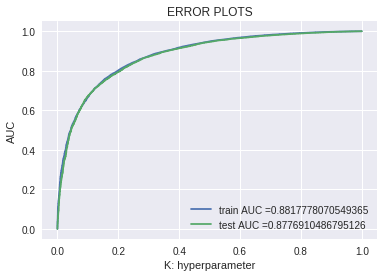

In [174]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

optimal_lambda = optimal_C['C']
neigh = LogisticRegression(C=optimal_lambda, penalty='l1')
neigh.fit(tfidf_sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(tfidf_sent_vectors_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Test data confusion matrix


Text(0.5, 1.0, 'Confusion Matrix')

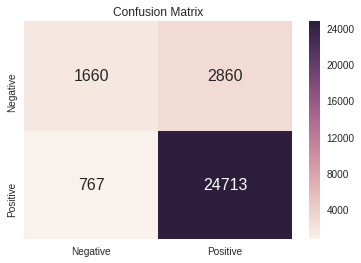

In [175]:
from sklearn.metrics import confusion_matrix
#Test  data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(tfidf_sent_vectors_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [176]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(tfidf_sent_vectors_test)))

              precision    recall  f1-score   support

           0       0.68      0.37      0.48      4520
           1       0.90      0.97      0.93     25480

   micro avg       0.88      0.88      0.88     30000
   macro avg       0.79      0.67      0.70     30000
weighted avg       0.86      0.88      0.86     30000



###[5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V

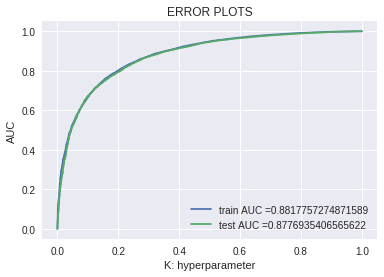

In [177]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

optimal_lambda = optimal_C['C']
neigh = LogisticRegression(C=optimal_lambda, penalty='l2')
neigh.fit(tfidf_sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(tfidf_sent_vectors_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Test data confusion matrix


Text(0.5, 1.0, 'Confusion Matrix')

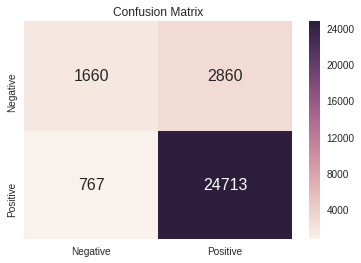

In [178]:
from sklearn.metrics import confusion_matrix
#Test  data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(tfidf_sent_vectors_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [179]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(tfidf_sent_vectors_test)))

              precision    recall  f1-score   support

           0       0.68      0.37      0.48      4520
           1       0.90      0.97      0.93     25480

   micro avg       0.88      0.88      0.88     30000
   macro avg       0.79      0.67      0.70     30000
weighted avg       0.86      0.88      0.86     30000



#[6]Feature Engineering

In [0]:
bow_1 = CountVectorizer(max_features=600)
X_train = bow_1.fit_transform(sample_data['CleanedText'].values)

In [0]:
X_train = X_train.todense()

In [182]:
print (X_train.shape)

(100000, 600)


In [0]:
length = []
for x in sample_data['Summary']:
    length.append(len(x))

In [0]:
length1 = np.asarray(length)

In [185]:
length1.shape

(100000,)

In [0]:
length2 = np.reshape(length1,(length1.shape[0],1))

In [0]:
Dataframe = np.hstack([X_train,length2])

In [0]:
#Breaking into Train and test
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(Dataframe,sample_data['Score'].values,test_size=0.3)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.0s finished


Best HyperParameter:  {'C': 1}
Best Accuracy: 89.82%


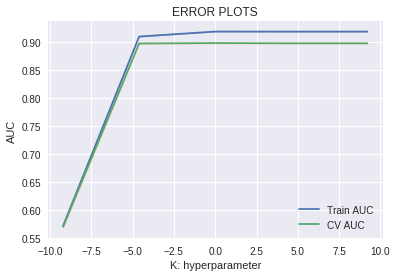

In [189]:
from sklearn.model_selection import GridSearchCV
from math import log
from sklearn.linear_model import LogisticRegression

K = [10**-4, 10**-2, 10**0, 10**2, 10**4]

Model= LogisticRegression()
parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]  
gsv = GridSearchCV(Model,parameters,cv=2,verbose=1,scoring = 'roc_auc' , n_jobs=-1)
gsv.fit(X_train,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']
optimal_C = gsv.best_params_
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

log_K = []
for i in K:
    log_K.append(log(i))

plt.plot(log_K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


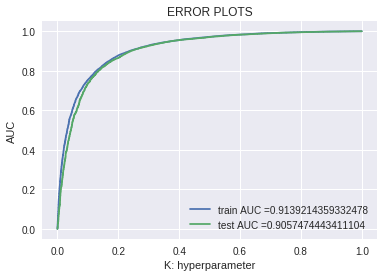

In [190]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

optimal_lambda = 1
neigh = LogisticRegression(C=optimal_lambda, penalty='l1')
neigh.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



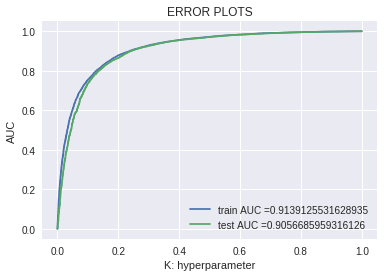

In [191]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

optimal_lambda = 1
neigh = LogisticRegression(C=optimal_lambda, penalty='l2')
neigh.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Test data confusion matrix


Text(0.5, 1.0, 'Confusion Matrix')

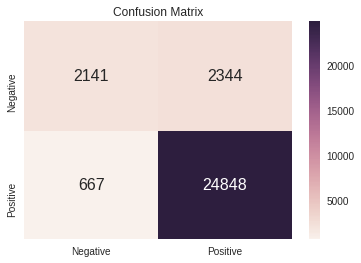

In [192]:
from sklearn.metrics import confusion_matrix
#Test data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(X_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [193]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.48      0.59      4485
           1       0.91      0.97      0.94     25515

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.84      0.73      0.77     30000
weighted avg       0.89      0.90      0.89     30000



#[7] Conclusions

###PrettyTable

In [194]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer",'',"F1","Recall","precision"]

x.add_row(["BOW",'L1',0.91,0.92,0.91])
x.add_row(['','L2',0.94,0.95,0.94])
x.add_row(["TF-IDF",'l1',0.78,0.75,0.73])
x.add_row(["",'L2',95,99,93])
x.add_row(["AVG W2V",'L1',0.81,0.86,0.84])
x.add_row(["",'L2',94,97,91])
x.add_row(["TF-IDF W2v",'L1',0.88,0.90,0.89])
x.add_row(["",'l2',93,97,90])

print(x)

+------------+----+------+--------+-----------+
| Vectorizer |    |  F1  | Recall | precision |
+------------+----+------+--------+-----------+
|    BOW     | L1 | 0.91 |  0.92  |    0.91   |
|            | L2 | 0.94 |  0.95  |    0.94   |
|   TF-IDF   | l1 | 0.78 |  0.75  |    0.73   |
|            | L2 |  95  |   99   |     93    |
|  AVG W2V   | L1 | 0.81 |  0.86  |    0.84   |
|            | L2 |  94  |   97   |     91    |
| TF-IDF W2v | L1 | 0.88 |  0.9   |    0.89   |
|            | l2 |  93  |   97   |     90    |
+------------+----+------+--------+-----------+


**1) So by performing logistic Regression we observed that high accuraccy was obtained for TF -IDF vectorizer**

**2) The accuraccy model can be increase by taking more data into consideration**